In [1]:
!nvidia-smi
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from csbdeep.utils import plot_history,plot_some
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Tue Aug  3 11:18:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:17:00.0  On |                  Off |
| 62%   80C    P2   243W / 260W |  23403MiB / 24211MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:73:00.0 Off |                  Off |
| 33%   

(20, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200902_92E_NITOM_day1_region1-1.tif
(18, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200902_92E_NITOM_day1_region4-1.tif
(16, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200903_90C_NITOM_day2_region2-1.tif
(17, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200903_90C_NITOM_day2_region4-1.tif
(15, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200903_90D_NITOM_day2_region6-1.tif
(12, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200903_92E_NITOM_day2_region1-1.tif
(21, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20200903_92E_NITOM_day2_region4-1.tif
(23, 1024, 1024) /home/sancere/Kep

(16, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20201016_100C_NITOM_day3_region7-1.tif
(21, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20201016_100D_NITOM_day3_region1-1.tif
(11, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20201016_100D_NITOM_day3_region5_zoom0.8-1.tif
(18, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20201016_100G_NITOM_day3_region1-1.tif
(26, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20201016_100G_NITOM_day3_region2-1.tif
(19, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210107_111C_N1TOM_day1_region2-1.tif
(16, 1024, 1024) /home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/20210107_111C_N1TOM_day1_region3-1.tif
(24, 1024, 1024) /h

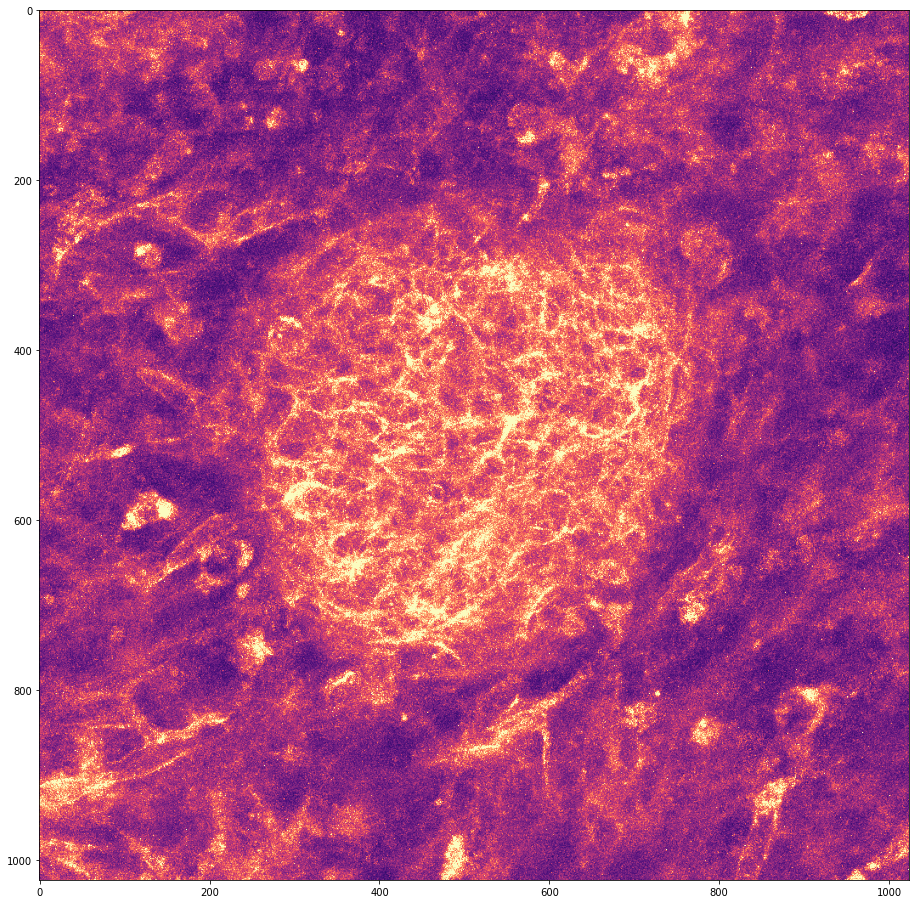

In [2]:
BaseDir =  '/home/sancere/Kepler/CurieTrainingDatasets/ClaudiaTomatoDenoising/Tomato_Denoising/'

Model_Dir = '/home/sancere/Kepler/CurieDeepLearningModels/ClaudiaTomatoDenoising/'
Model_Name = 'N2VTomato'

datagen = N2V_DataGenerator()

imgs = datagen.load_imgs_from_directory(directory = BaseDir , dims='ZYX')
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()





99
Generated patches: (160, 8, 512, 512, 1)
(157, 8, 512, 512, 1) (3, 8, 512, 512, 1)


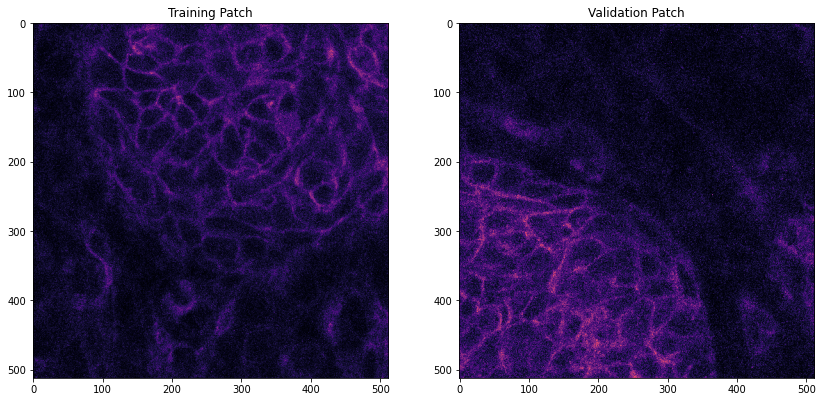

In [10]:

patch_shape = (8, 512, 512)
Epochs = 200
NetworkDepth = 3
batch_size = 1
patches = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape,num_patches_per_img = 20)
X = patches[:-3]
X_val = patches[patches.shape[0]-3:]
print(X.shape, X_val.shape)
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,1,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,1,...,0],cmap='magma')
plt.title('Validation Patch');

In [11]:
config = N2VConfig(X, unet_kern_size=3, unet_n_depth = NetworkDepth,
                   train_steps_per_epoch=400,train_epochs= Epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=batch_size, n2v_perc_pix=0.198,n2v_patch_shape= patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=4, train_checkpoint ='weights_now.h5' )

# Let's look at the parameters stored in the config-object.

model = N2V(config=config, name=Model_Name, basedir=Model_Dir)
vars(config)

/home/sancere/anaconda3/envs/tensorflowGPU/lib/python3.7/site-packages/n2v/models/n2v_standard.py:418: UserWarning: output path for model already exists, files may be overwritten: /home/sancere/Kepler/CurieDeepLearningModels/ClaudiaTomatoDenoising/N2VTomato
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2021-08-03 11:27:23.231634: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-03 11:27:23.279908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:73:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-08-03 11:27:23.280177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-08-03 11:27:23.281780: I tensorflow/stream_executor/platform/default

{'means': ['14.325109'],
 'stds': ['10.328808'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 1,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_now.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (8, 512, 512),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 4,
 'single_net_per_channel': True,
 'structN2Vmask': None,
 'probabilistic': False}

In [12]:

history = model.train(X, X_val)

/home/sancere/anaconda3/envs/tensorflowGPU/lib/python3.7/site-packages/n2v/models/n2v_standard.py:194: UserWarning: small number of validation images (only 1.9% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))
Using TensorFlow backend.
Preparing validation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 63.50it/s]

4152 blind-spots will be generated per training patch of size (8, 512, 512).
Epoch 1/200



2021-08-03 11:27:34.722639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-08-03 11:27:36.038212: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


400/400 [==============================] - 207s 516ms/step - loss: 0.5991 - n2v_mse: 0.5991 - n2v_abs: 0.5911 - val_loss: 0.3969 - val_n2v_mse: 0.3969 - val_n2v_abs: 0.4905 - lr: 4.0000e-04
Epoch 2/200
400/400 [==============================] - 205s 513ms/step - loss: 0.5600 - n2v_mse: 0.5600 - n2v_abs: 0.5692 - val_loss: 0.3837 - val_n2v_mse: 0.3837 - val_n2v_abs: 0.4758 - lr: 4.0000e-04
Epoch 3/200
400/400 [==============================] - 205s 513ms/step - loss: 0.5193 - n2v_mse: 0.5193 - n2v_abs: 0.5492 - val_loss: 0.3907 - val_n2v_mse: 0.3907 - val_n2v_abs: 0.4837 - lr: 4.0000e-04
Epoch 4/200
400/400 [==============================] - 205s 513ms/step - loss: 0.4904 - n2v_mse: 0.4904 - n2v_abs: 0.5340 - val_loss: 0.3870 - val_n2v_mse: 0.3870 - val_n2v_abs: 0.4696 - lr: 4.0000e-04
Epoch 5/200
400/400 [==============================] - 205s 513ms/step - loss: 0.4913 - n2v_mse: 0.4913 - n2v_abs: 0.5345 - val_loss: 0.3900 - val_n2v_mse: 0.3900 - val_n2v_abs: 0.4726 - lr: 4.0000e-04
Ep

Epoch 38/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4785 - n2v_mse: 0.4785 - n2v_abs: 0.5252 - val_loss: 0.3789 - val_n2v_mse: 0.3789 - val_n2v_abs: 0.4741 - lr: 4.0000e-09
Epoch 39/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4692 - n2v_mse: 0.4692 - n2v_abs: 0.5199 - val_loss: 0.3786 - val_n2v_mse: 0.3786 - val_n2v_abs: 0.4740 - lr: 4.0000e-09
Epoch 40/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4793 - n2v_mse: 0.4793 - n2v_abs: 0.5267 - val_loss: 0.3791 - val_n2v_mse: 0.3791 - val_n2v_abs: 0.4741 - lr: 4.0000e-09
Epoch 41/200
400/400 [==============================] - ETA: 0s - loss: 0.4749 - n2v_mse: 0.4749 - n2v_abs: 0.5243
Epoch 00041: ReduceLROnPlateau reducing learning rate to 3.999999886872274e-10.
400/400 [==============================] - 205s 512ms/step - loss: 0.4749 - n2v_mse: 0.4749 - n2v_abs: 0.5243 - val_loss: 0.3789 - val_n2v_mse: 0.3789 - val_n2v_abs: 0.4741 - lr: 4.0000e-09
Epoch 

400/400 [==============================] - 205s 512ms/step - loss: 0.4743 - n2v_mse: 0.4743 - n2v_abs: 0.5229 - val_loss: 0.3791 - val_n2v_mse: 0.3791 - val_n2v_abs: 0.4742 - lr: 4.0000e-17
Epoch 72/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4729 - n2v_mse: 0.4729 - n2v_abs: 0.5233 - val_loss: 0.3792 - val_n2v_mse: 0.3792 - val_n2v_abs: 0.4742 - lr: 4.0000e-17
Epoch 73/200
400/400 [==============================] - ETA: 0s - loss: 0.4719 - n2v_mse: 0.4719 - n2v_abs: 0.5226
Epoch 00073: ReduceLROnPlateau reducing learning rate to 3.999999604228391e-18.
400/400 [==============================] - 205s 512ms/step - loss: 0.4719 - n2v_mse: 0.4719 - n2v_abs: 0.5226 - val_loss: 0.3789 - val_n2v_mse: 0.3789 - val_n2v_abs: 0.4741 - lr: 4.0000e-17
Epoch 74/200
400/400 [==============================] - 205s 513ms/step - loss: 0.4711 - n2v_mse: 0.4711 - n2v_abs: 0.5227 - val_loss: 0.3787 - val_n2v_mse: 0.3787 - val_n2v_abs: 0.4740 - lr: 4.0000e-18
Epoch 75/200
400/40

400/400 [==============================] - 205s 512ms/step - loss: 0.4693 - n2v_mse: 0.4693 - n2v_abs: 0.5205 - val_loss: 0.3789 - val_n2v_mse: 0.3789 - val_n2v_abs: 0.4742 - lr: 4.0000e-25
Epoch 105/200
400/400 [==============================] - ETA: 0s - loss: 0.4688 - n2v_mse: 0.4688 - n2v_abs: 0.5212
Epoch 00105: ReduceLROnPlateau reducing learning rate to 4.0000000781659256e-26.
400/400 [==============================] - 205s 513ms/step - loss: 0.4688 - n2v_mse: 0.4688 - n2v_abs: 0.5212 - val_loss: 0.3790 - val_n2v_mse: 0.3790 - val_n2v_abs: 0.4740 - lr: 4.0000e-25
Epoch 106/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4725 - n2v_mse: 0.4725 - n2v_abs: 0.5225 - val_loss: 0.3790 - val_n2v_mse: 0.3790 - val_n2v_abs: 0.4740 - lr: 4.0000e-26
Epoch 107/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4708 - n2v_mse: 0.4708 - n2v_abs: 0.5227 - val_loss: 0.3788 - val_n2v_mse: 0.3788 - val_n2v_abs: 0.4741 - lr: 4.0000e-26
Epoch 108/200
4

400/400 [==============================] - ETA: 0s - loss: 0.4753 - n2v_mse: 0.4753 - n2v_abs: 0.5250
Epoch 00137: ReduceLROnPlateau reducing learning rate to 3.999999727626927e-34.
400/400 [==============================] - 205s 512ms/step - loss: 0.4753 - n2v_mse: 0.4753 - n2v_abs: 0.5250 - val_loss: 0.3792 - val_n2v_mse: 0.3792 - val_n2v_abs: 0.4742 - lr: 4.0000e-33
Epoch 138/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4734 - n2v_mse: 0.4734 - n2v_abs: 0.5225 - val_loss: 0.3791 - val_n2v_mse: 0.3791 - val_n2v_abs: 0.4739 - lr: 4.0000e-34
Epoch 139/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4735 - n2v_mse: 0.4735 - n2v_abs: 0.5239 - val_loss: 0.3791 - val_n2v_mse: 0.3791 - val_n2v_abs: 0.4740 - lr: 4.0000e-34
Epoch 140/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4718 - n2v_mse: 0.4718 - n2v_abs: 0.5213 - val_loss: 0.3787 - val_n2v_mse: 0.3787 - val_n2v_abs: 0.4740 - lr: 4.0000e-34
Epoch 141/200
40

Epoch 170/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4761 - n2v_mse: 0.4761 - n2v_abs: 0.5252 - val_loss: 0.3786 - val_n2v_mse: 0.3786 - val_n2v_abs: 0.4739 - lr: 3.9993e-42
Epoch 171/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4809 - n2v_mse: 0.4809 - n2v_abs: 0.5265 - val_loss: 0.3795 - val_n2v_mse: 0.3795 - val_n2v_abs: 0.4742 - lr: 3.9993e-42
Epoch 172/200
400/400 [==============================] - 205s 512ms/step - loss: 0.4721 - n2v_mse: 0.4721 - n2v_abs: 0.5223 - val_loss: 0.3790 - val_n2v_mse: 0.3790 - val_n2v_abs: 0.4741 - lr: 3.9993e-42
Epoch 173/200
400/400 [==============================] - ETA: 0s - loss: 0.4776 - n2v_mse: 0.4776 - n2v_abs: 0.5251
Epoch 00173: ReduceLROnPlateau reducing learning rate to 3.9993058171830284e-43.
400/400 [==============================] - 205s 512ms/step - loss: 0.4776 - n2v_mse: 0.4776 - n2v_abs: 0.5251 - val_loss: 0.3790 - val_n2v_mse: 0.3790 - val_n2v_abs: 0.4741 - lr: 3.9993e-42
E

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


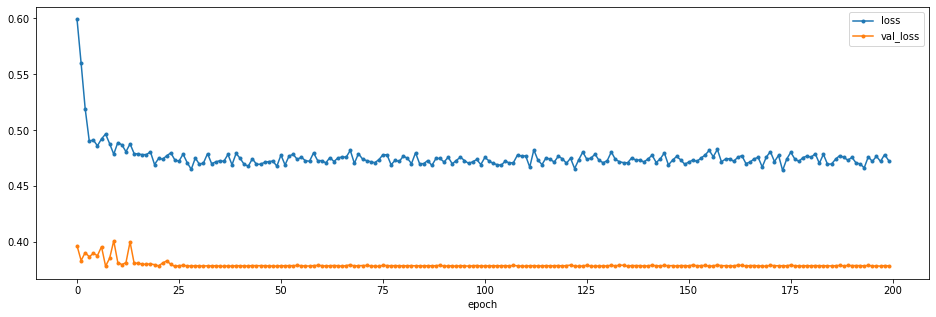

In [13]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

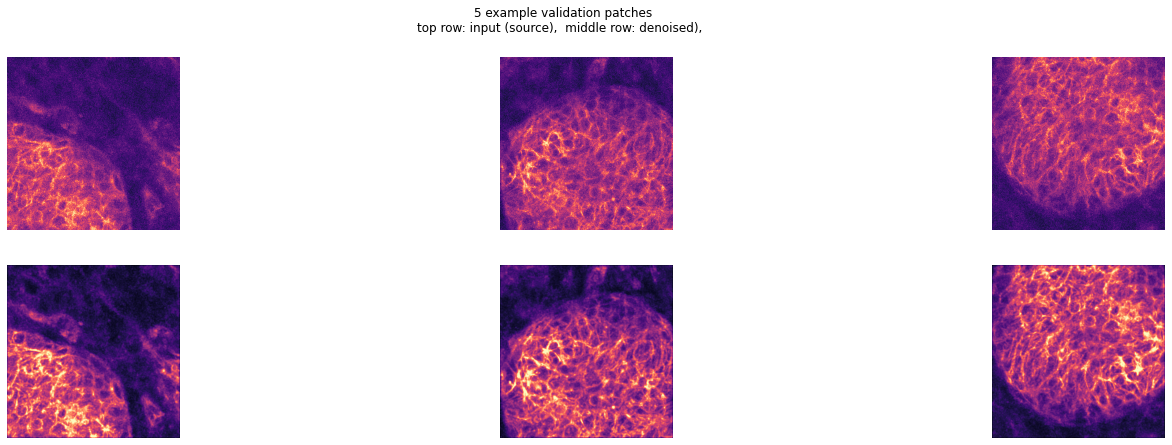

In [14]:
plt.figure(figsize=(25,7))
_P = model.keras_model.predict(X_val[:5])

plot_some(X_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: denoised),  '
             );